In [ ]:
from google.colab import drive
import os
import sys
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input, Model, Sequential
from sklearn.model_selection import train_test_split

drive.mount("/content/drive", force_remount=True)
try:
    my_path = "/content/notebooks"
    os.symlink("/content/drive/MyDrive/ColabNotebooks/my_env", my_path)
    sys.path.insert(0, my_path)
except:
    pass
os.chdir(my_path)

def set_css():
  display(HTML("""
  <style>
    pre {white-space: pre-wrap;}
  </style>
  """))
get_ipython().events.register("pre_run_cell", set_css)

plt.style.use("dark_background")

Mounted at /content/drive


In [ ]:
(x_tr, y_tr), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_tr = tf.keras.utils.to_categorical(y_tr)
y_test = tf.keras.utils.to_categorical(y_test)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, train_size=0.8, shuffle=True, random_state=777)

gen_tr = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
gen_val = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
def Res_18(x, filter): 
    f = filter

    fx = Conv2D(filters=f, kernel_size=(3, 3), strides=1, padding="same")(x) 
    fx = BatchNormalization()(fx)
    fx = Activation("relu")(fx)
    fx = Conv2D(filters=f, kernel_size=(3, 3), strides=1, padding="same")(fx)
    fx = BatchNormalization()(fx)
    fx = Activation("relu")(fx)

    def se_block(x, c, r=16):
        z = GlobalAveragePooling2D()(x)
        z = Dense(units=c//r, activation="relu")(z)
        z = Dense(units=c, activation="sigmoid")(z)
        z = Reshape(target_shape=(1, 1, c))(z)
        return z*x
    
    fx = se_block(fx, c=f, r=16)

    skip = Conv2D(filters=f, kernel_size=(1, 1), strides=1, padding="same")(x)
    skip = BatchNormalization()(skip)

    add = Add()([fx, skip])
    hx = Activation("relu")(add)
    return hx

inputs = Input(shape=(32, 32, 3))
z = Conv2D(filters=64, kernel_size=7, strides=2, padding="valid")(inputs)
z = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")(z)
for _ in range(2):
    z = Res_18(z, filter=64)
for _ in range(2):
    z = Res_18(z, filter=128)
for _ in range(2):
    z = Res_18(z, filter=256)
for _ in range(2):
    z = Res_18(z, filter=512)
z = GlobalAveragePooling2D()(z) 
outputs = Dense(units=10, activation="softmax")(z)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

es = EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=2)
model_path = "SE-ResNet18_cifar10.h5"
mc = ModelCheckpoint(filepath=model_path, monitor="val_accuracy", mode="auto", verbose=1, save_best_only=True)

epochs=20
hist = model.fit(x=gen_tr.flow(x_tr, y_tr, batch_size=32), validation_data=gen_val.flow(x_val, y_val, batch_size=32),
                 epochs=epochs, callbacks=[es, mc])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 13, 13, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 7, 7, 64)     0           conv2d_53[0][0]                  
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 7, 7, 64)     36928       max_pooling2d_3[0][0]            
____________________________________________________________________________________________

KeyboardInterrupt: ignored

- https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/applications/resnet.py

```python
def Res_50(x, filters): 
    f1, f2 = filters

    fx = Conv2D(filters=f1, kernel_size=(1, 1), strides=1, padding="same")(x) 
    fx = BatchNormalization()(fx)
    fx = Activation("relu")(fx)
    fx = Conv2D(filters=f1, kernel_size=(3, 3), strides=1, padding="same")(fx)
    fx = BatchNormalization()(fx)
    fx = Activation("relu")(fx)
    fx = Conv2D(filters=f2, kernel_size=(1, 1), strides=1, padding="same")(fx)
    fx = BatchNormalization()(fx)
    fx = Activation("relu")(fx)
    fx = SEmodule(fx, f2, 16)

    skip = Conv2D(filters=f2, kernel_size=(1, 1), strides=1, padding="same")(x)
    skip = BatchNormalization()(skip)

    add = Add()([fx, skip])
    hx = Activation("relu")(add)    
    
    return hx

for _ in range(3):
    z = Res_50(z, filters=[64, 256])
for _ in range(4):
    z = Res_50(z, filters=[128, 512])
for _ in range(6):
    z = Res_50(z, filters=[256, 1024])
for _ in range(3):
    z = Res_50(z, filters=[512, 2048])
```

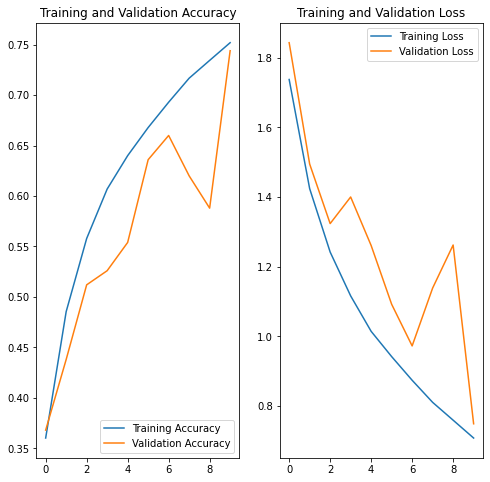

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()